In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disflqa-bilstm/disflqa-bilstm-dev.csv
/kaggle/input/disflqa-bilstm/disflqa-bilstm-test.csv
/kaggle/input/disflqa-bilstm/disflqa-bilstm-train.csv


In [ ]:
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [6]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [7]:
data = pd.read_csv("/kaggle/input/disflqa-bilstm/disflqa-bilstm-train.csv")

In [8]:
data

,Sentence,Word,POS,TAG
0,0,what,PRON,O
1,0,do,AUX,O
2,0,petrologists,NOUN,BR
3,0,no,INTJ,IR
4,0,what,PRON,IR
...,...,...,...,...
100396,7178,did,AUX,O
100397,7178,kusala,PROPN,O
100398,7178,have,VERB,O
100399,7178,a,DET,O


In [9]:
words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
tags = list(set(data["TAG"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)
print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of words in the dataset:  8526
Tags: ['O', 'BR', 'IR']
Number of Labels:  3
What the dataset looks like:


,Sentence,Word,POS,TAG
0,0,what,PRON,O
1,0,do,AUX,O
2,0,petrologists,NOUN,BR
3,0,no,INTJ,IR
4,0,what,PRON,IR
5,0,do,VERB,IR
6,0,unstable,ADJ,O
7,0,isotope,NOUN,O
8,0,studies,NOUN,O
9,0,indicate,VERB,O


In [10]:
ls = []
ls.append((data['Word'][0], data['POS'][0], data['TAG'][0]))

In [11]:
ls

[('what', 'PRON', 'O')]

In [12]:
#Converting into 3 way tuples
maxNum = data['Sentence'][len(data)-1]

#get a sentence and its tuple ordering
sentences = []
sentence = []
initval = 0
for i in range(0, len(data)):
    if(data['Sentence'][i] == initval):
        sentence.append((data['Word'][i], data['POS'][i], data['TAG'][i]))
    else:
        sentences.append(sentence)
        sentence = []
        initval = data['Sentence'][i]
        sentence.append((data['Word'][i], data['POS'][i], data['TAG'][i]))
    

In [13]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

In [14]:
# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

In [15]:
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

In [16]:
# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

In [17]:
print("The word oBAMA is identified by the index: {}".format(word2idx["obama"]))

The word oBAMA is identified by the index: 3640


In [18]:
print("The label IR is indicated by the tag: {}".format(tag2idx["IR"]))

The label IR is indicated by the tag: 3


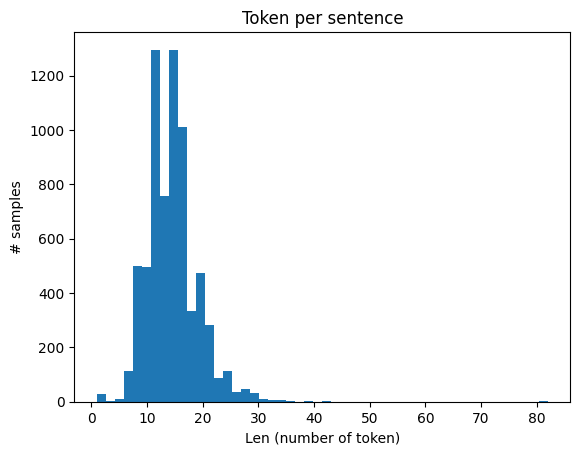

In [19]:
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [20]:
from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

In [21]:
# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

In [22]:
from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

In [23]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((6242, 75), (694, 75), (6242, 75, 4), (694, 75, 4))

In [24]:
print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

Raw Sample:  what do petrologists no what do unstable isotope studies indicate
Raw Label:  O O BR IR IR IR O O O O
After processing, sample: [4325 5505 6855 6744 4325 5505 6759  845 7464  998    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
After processing, labels: [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 

In [ ]:
# from keras.models import Model
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
# from keras_contrib.layers import CRF
# # Model definition
# input = Input(shape=(MAX_LEN,))
# model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
#                   input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
# model = Bidirectional(LSTM(units=50, return_sequences=True,
#                            recurrent_dropout=0.1))(model)  # variational biLSTM
# model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
# crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
# out = crf(model)  # output
# model = Model(input, out)
# model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
# model.summary()

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
# import tensorflow_addons as tfa

# # Model definition
# input = Input(shape=(MAX_LEN,))
# model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, input_length=MAX_LEN, mask_zero=True)(input)
# model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model)
# model = TimeDistributed(Dense(50, activation="relu"))(model)
# crf = tfa.layers.CRF(n_tags+1)  # CRF layer, n_tags+1 (PAD)
# out = crf(model)  # output
# model = Model(input, out)

# # Define custom loss function and metrics for CRF
# def custom_loss(y_true, y_pred):
#     return -crf.log_likelihood(y_true, y_pred)

# def custom_accuracy(y_true, y_pred):
#     return tf.reduce_mean(crf.viterbi_accuracy(y_true, y_pred))

# model.compile(optimizer="rmsprop", loss=custom_loss, metrics=[custom_accuracy])
# model.summary()




In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
# import tensorflow_addons as tfa

# # Model definition
# input = Input(shape=(MAX_LEN,))
# model = Embedding(input_dim=n_words + 2, output_dim=EMBEDDING, input_length=MAX_LEN, mask_zero=True)(input)
# model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model)
# model = TimeDistributed(Dense(50, activation="relu"))(model)
# crf = tfa.layers.CRF(n_tags + 1)  # CRF layer, n_tags+1 (PAD)
# out = crf(model)  # output
# model = Model(input, out)

# # Define custom loss function using CRF log likelihood
# def custom_loss(y_true, y_pred):
#     # Compute negative log-likelihood loss
#     log_likelihood, _ = tfa.text.crf_log_likelihood(
#         inputs=y_pred,
#         tag_indices=y_true,
#         sequence_lengths=tf.reduce_sum(tf.cast(tf.math.not_equal(y_true, 0), dtype=tf.int32), axis=1),
#         transition_params=crf.transitional_params
#     )
#     return -tf.reduce_mean(log_likelihood)

# # Define custom accuracy function for CRF
# def custom_accuracy(y_true, y_pred):
#     # Get predicted sequences
#     _, potentials, sequence_length, _ = crf(y_pred)
#     predicted_sequences, _ = tfa.text.crf_decode(potentials, crf.transitional_params, sequence_length)

#     # Convert true sequences to match predicted sequences shape
#     true_sequences = tf.cast(y_true, dtype=tf.int32)

#     # Compare predicted sequences with true sequences
#     correct_predictions = tf.reduce_all(tf.equal(predicted_sequences, true_sequences), axis=1)

#     # Compute accuracy
#     accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

#     return accuracy

# model.compile(optimizer="rmsprop", loss=custom_loss, metrics=[custom_accuracy])
# model.summary()


In [25]:
#without crf
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input

# Model definition
input_layer = Input(shape=(MAX_LEN,))
embedding = Embedding(input_dim=n_words + 2, output_dim=EMBEDDING, input_length=MAX_LEN, mask_zero=True)(input_layer)
bi_lstm = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(embedding)
time_distributed = TimeDistributed(Dense(50, activation="relu"))(bi_lstm)
output_layer = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(time_distributed)

model = Model(input_layer, output_layer)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 20)            170560    
                                                                 
 bidirectional (Bidirection  (None, 75, 100)           28400     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 75, 50)            5050      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 75, 4)             204       
 stributed)                                                      
                                                             

In [ ]:
#  history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=20,validation_split=0.1, verbose=2)


In [32]:

from tensorflow.keras.callbacks import ModelCheckpoint
import os

checkpoint_path = '/kaggle/working/model_checkpoints/'
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# Define the filepath for the checkpoint
checkpoint_filepath = checkpoint_path + 'model_checkpoint.h5'

# Create a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',  # Monitors validation loss to save the best model
    save_best_only=True,  # Saves only the best model
    mode='min',  # Considers minimizing the monitored quantity
    verbose=1  # Shows the progress of saving checkpoints
)

# Assuming 'model' is your defined neural network model
history = model.fit(
    X_tr,
    np.array(y_tr),
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.1,
    callbacks=[checkpoint],  # Include the checkpoint callback
    verbose=2
)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.58712, saving model to /kaggle/working/model_checkpoints/model_checkpoint.h5
176/176 - 29s - loss: 0.7857 - accuracy: 0.6679 - val_loss: 0.5871 - val_accuracy: 0.7797 - 29s/epoch - 165ms/step
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.58712 to 0.52916, saving model to /kaggle/working/model_checkpoints/model_checkpoint.h5
176/176 - 22s - loss: 0.5494 - accuracy: 0.7807 - val_loss: 0.5292 - val_accuracy: 0.7862 - 22s/epoch - 124ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.52916 to 0.49616, saving model to /kaggle/working/model_checkpoints/model_checkpoint.h5
176/176 - 22s - loss: 0.4961 - accuracy: 0.7997 - val_loss: 0.4962 - val_accuracy: 0.7993 - 22s/epoch - 123ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.49616 to 0.47405, saving model to /kaggle/working/model_checkpoints/model_checkpoint.h5
176/176 - 21s - loss: 0.4617 - accuracy: 0.8148 - val_loss: 0.4741 - val_accuracy: 0.8118 - 21s/epoch - 120ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.47405 to 0.46776, saving model to /kaggle/working/model_checkpoints/model_checkpoint.h5
176/176 - 22s - loss: 0.4330 - accuracy: 0.8277 - val_loss: 0.4678 - val_accuracy: 0.8168 - 22s/epoch - 123ms/step
Epoch 6/20

Epo

In [33]:
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

22/22 [==============================] - 1s 24ms/step


In [36]:
from sklearn.metrics import classification_report
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

pred_tag_flat = np.concatenate(pred_tag)
y_te_true_tag_flat = np.concatenate(y_te_true_tag)

report = classification_report(y_pred=pred_tag_flat, y_true=y_te_true_tag_flat)
print(report)

# report = classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
# print(report)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          BR       0.01      0.45      0.02       768
          IR       0.70      0.80      0.75      3093
           O       0.88      0.85      0.86      6184
         PAD       0.00      0.00      0.00     42005

    accuracy                           0.15     52050
   macro avg       0.40      0.52      0.41     52050
weighted avg       0.15      0.15      0.15     52050



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
#With bidirectional GRU
from keras.models import Model
from keras.layers import GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input

# Model definition
input_layer = Input(shape=(MAX_LEN,))
embedding = Embedding(input_dim=n_words + 2, output_dim=EMBEDDING, input_length=MAX_LEN, mask_zero=True)(input_layer)
bi_gru = Bidirectional(GRU(units=50, return_sequences=True, recurrent_dropout=0.1))(embedding)
time_distributed = TimeDistributed(Dense(50, activation="relu"))(bi_gru)
output_layer = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(time_distributed)

model = Model(input_layer, output_layer)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 75, 20)            170560    
                                                                 
 bidirectional_1 (Bidirecti  (None, 75, 100)           21600     
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 75, 50)            5050      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 75, 4)             204       
 stributed)                                                      
                                                           

In [38]:

from tensorflow.keras.callbacks import ModelCheckpoint
import os

checkpoint_path = '/kaggle/working/model_checkpoints/'
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# Define the filepath for the checkpoint
checkpoint_filepath = checkpoint_path + 'model_checkpointGRU.h5'

# Create a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',  # Monitors validation loss to save the best model
    save_best_only=True,  # Saves only the best model
    mode='min',  # Considers minimizing the monitored quantity
    verbose=1  # Shows the progress of saving checkpoints
)

# Assuming 'model' is your defined neural network model
history = model.fit(
    X_tr,
    np.array(y_tr),
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.1,
    callbacks=[checkpoint],  # Include the checkpoint callback
    verbose=2
)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.56061, saving model to /kaggle/working/model_checkpoints/model_checkpointGRU.h5
176/176 - 26s - loss: 0.7165 - accuracy: 0.7179 - val_loss: 0.5606 - val_accuracy: 0.7792 - 26s/epoch - 147ms/step
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.56061 to 0.55510, saving model to /kaggle/working/model_checkpoints/model_checkpointGRU.h5
176/176 - 19s - loss: 0.5440 - accuracy: 0.7819 - val_loss: 0.5551 - val_accuracy: 0.7797 - 19s/epoch - 111ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.55510 to 0.51561, saving model to /kaggle/working/model_checkpoints/model_checkpointGRU.h5
176/176 - 19s - loss: 0.5021 - accuracy: 0.8016 - val_loss: 0.5156 - val_accuracy: 0.8043 - 19s/epoch - 107ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.51561 to 0.50912, saving model to /kaggle/working/model_checkpoints/model_checkpointGRU.h5
176/176 - 19s - loss: 0.4652 - accuracy: 0.8182 - val_loss: 0.5091 - val_accuracy: 0.7994 - 19s/epoch - 108ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 0.50912
176/176 - 19s - loss: 0.4338 - accuracy: 0.8316 - val_loss: 0.5183 - val_accuracy: 0.7885 - 19s/epoch - 108ms/step
Epoch 6/20

Epoch 6: val_loss improved from 0.50912 to 0.48703, saving model to /

In [40]:
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

22/22 [==============================] - 1s 26ms/step


In [41]:
from sklearn.metrics import classification_report
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

pred_tag_flat = np.concatenate(pred_tag)
y_te_true_tag_flat = np.concatenate(y_te_true_tag)

report = classification_report(y_pred=pred_tag_flat, y_true=y_te_true_tag_flat)
print(report)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          BR       0.58      0.47      0.52       768
          IR       0.69      0.79      0.74      3093
           O       0.11      0.83      0.19      6184
         PAD       0.00      0.00      0.00     42005

    accuracy                           0.15     52050
   macro avg       0.35      0.52      0.36     52050
weighted avg       0.06      0.15      0.07     52050



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
